Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from keras import layers
from keras.models import Sequential

### Importing Skin Cancer Data

In [2]:
## Mounting the data from google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Skin_cancer_ISIC/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin_cancer_ISIC/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2262
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir_train, 
    batch_size=batch_size, 
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed=123,
    validation_split=0.2,
    subset="training"
    )

Found 11262 files belonging to 9 classes.
Using 9010 files for training.


In [ ]:
val_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir_train, 
    batch_size=batch_size, 
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed=123,
    validation_split=0.2,
    subset="validation"
    )

Found 2262 files belonging to 9 classes.
Using 452 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

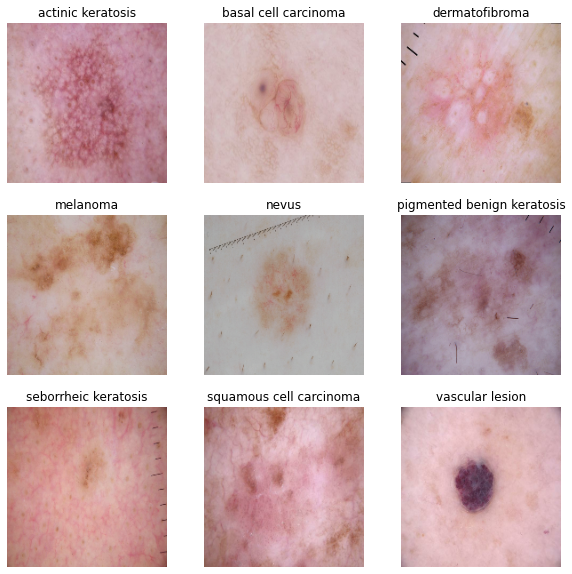

In [8]:
### To visualize the images
plt.figure(figsize=(10, 10))
for i in range(len(class_names)):

    filtered_ds = train_ds.filter(lambda x, l: l[0] == i)
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

# Plotting the images
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [ ]:
model = Sequential()
model.add(layers.Rescaling(1./255))

model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_names), activation='softmax'))

### Compile the model

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
input_shape = (None, img_height, img_width, 3)
model.build(input_shape) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 178, 178, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 147s 3s/step - loss: 4.5727 - accuracy: 0.3304 - val_loss: 8.0386 - val_accuracy: 0.0420
Epoch 2/20
57/57 [==============================] - 6s 100ms/step - loss: 1.6891 - accuracy: 0.4166 - val_loss: 9.2704 - val_accuracy: 0.0420
Epoch 3/20
57/57 [==============================] - 6s 100ms/step - loss: 1.4984 - accuracy: 0.4823 - val_loss: 7.4137 - val_accuracy: 0.0420
Epoch 4/20
57/57 [==============================] - 6s 100ms/step - loss: 1.4034 - accuracy: 0.5061 - val_loss: 5.6058 - val_accuracy: 0.1726
Epoch 5/20
57/57 [==============================] - 6s 101ms/step - loss: 1.3096 - accuracy: 0.5215 - val_loss: 4.6434 - val_accuracy: 0.2257
Epoch 6/20
57/57 [==============================] - 6s 101ms/step - loss: 1.1764 - accuracy: 0.5829 - val_loss: 3.1417 - val_accuracy: 0.3385
Epoch 7/20
57/57 [==============================] - 6s 101ms/step - loss: 1.0804 - accuracy: 0.6249 - val_loss: 3.9388 - val_accuracy: 0.3031
Epoch 8

### Visualizing training results

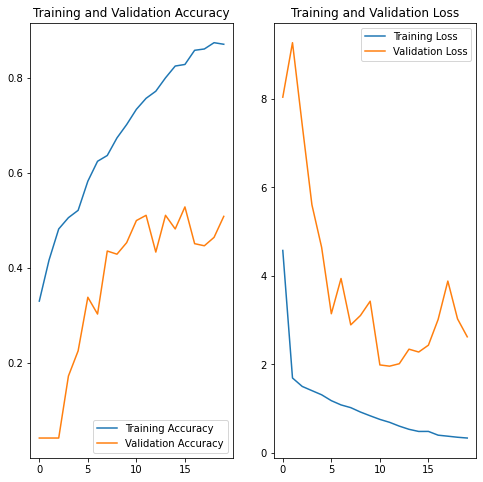

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings
There is a big gap between training and validation accuracy, the model is overfitting despite of us using dropouts and experimenting with various number of layers and layer shapes. Therefore we probably need more data to get a better fit. We can use data augmentation to generate more data.

### Data Augmentation

In [ ]:
# create data generator
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
                rotation_range=30,
                width_shift_range=0.1,
                height_shift_range=0.1,
                brightness_range=[0.4,1.2],
                zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=True,
                validation_split=0.2)

In [ ]:
sample_ds = train_ds.take(1)

In [ ]:
aug_iter = datagen.flow(sample_ds.get_single_element()[0][1].numpy().reshape(1,180,180,3), batch_size=1)

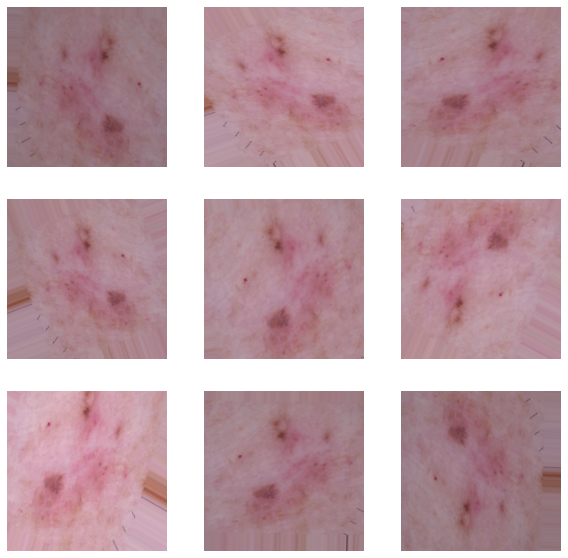

In [ ]:
# generate samples and plot
plt.figure(figsize=(10, 10))

# generate batch of images
for i in range(9):
	# convert to unsigned integers
  image = next(aug_iter)[0].astype('uint8')
 
	# plot image
  plt.subplot(3, 3, i+1)
  plt.imshow(image)
  plt.axis('off')

In [ ]:
train_generator = datagen.flow_from_directory(
                  directory=data_dir_train,
                  target_size=(img_height, img_width), # resize to this size
                  batch_size=32, # number of images to extract from folder for every batch
                  class_mode="categorical", # classes to predict
                  seed=123, # to make the result reproducible,
                  subset="training"
                  )

val_generator = datagen.flow_from_directory(
                  directory=data_dir_train,
                  target_size=(img_height, img_width), # resize to this size
                  batch_size=32, # number of images to extract from folder for every batch
                  class_mode="categorical", # classes to predict
                  seed=123, # to make the result reproducible,
                  subset="validation"
                  )

Found 1813 images belonging to 9 classes.
Found 449 images belonging to 9 classes.


### Create the model, compile and train the model


In [ ]:
model_2 = Sequential()
model_2.add(layers.Rescaling(1./255))

model_2.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_2.add(layers.Dropout(0.25))

model_2.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_2.add(layers.Dropout(0.25))

model_2.add(layers.Flatten())
model_2.add(layers.Dense(512, activation='relu'))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(len(class_names), activation='softmax'))

### Compiling the model

In [ ]:
model_2.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# View the summary of all layers
model_2.build(input_shape) 
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 batch_normalization_5 (Batc  (None, 178, 178, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 32)      

### Training the new model with augmented data

In [ ]:
epochs=20
history_augmented = model_2.fit(
  train_generator,
  validation_data=val_generator,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 55s 964ms/step - loss: 8.3412 - accuracy: 0.1881 - val_loss: 6.0572 - val_accuracy: 0.1492
Epoch 2/20
57/57 [==============================] - 55s 961ms/step - loss: 1.9504 - accuracy: 0.3078 - val_loss: 9.2870 - val_accuracy: 0.1826
Epoch 3/20
57/57 [==============================] - 53s 937ms/step - loss: 1.8227 - accuracy: 0.3525 - val_loss: 11.0733 - val_accuracy: 0.2116
Epoch 4/20
57/57 [==============================] - 53s 935ms/step - loss: 1.7458 - accuracy: 0.3938 - val_loss: 11.3136 - val_accuracy: 0.2116
Epoch 5/20
57/57 [==============================] - 53s 939ms/step - loss: 1.7408 - accuracy: 0.3883 - val_loss: 11.5645 - val_accuracy: 0.2116
Epoch 6/20
57/57 [==============================] - 55s 963ms/step - loss: 1.6944 - accuracy: 0.4026 - val_loss: 7.1579 - val_accuracy: 0.2650
Epoch 7/20
57/57 [==============================] - 53s 935ms/step - loss: 1.6930 - accuracy: 0.4109 - val_loss: 4.7011 - val_accuracy: 0.3

### Visualizing the results

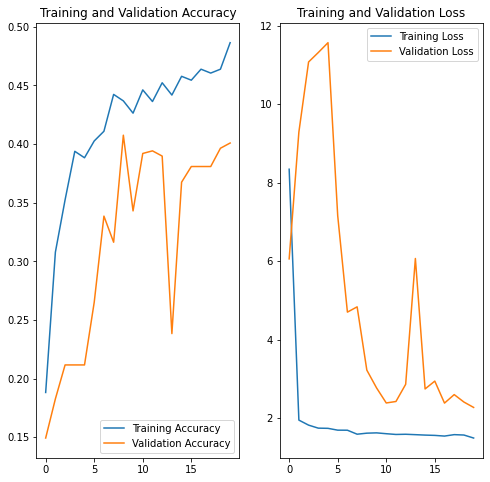

In [ ]:
acc = history_augmented.history['accuracy']
val_acc = history_augmented.history['val_accuracy']

loss = history_augmented.history['loss']
val_loss = history_augmented.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings
The overfitting issue seems to have been resolved, now the training and validation accuracy has reduced. But the accuracy is not great. Training accuracy has come down a lot and validation accuracy has not improved.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
from glob import glob

classes = os.listdir(data_dir_train)
for x in classes:
  print(x, len(os.listdir(os.path.join(data_dir_train, x))))

melanoma 450
dermatofibroma 96
basal cell carcinoma 377
nevus 362
vascular lesion 140
pigmented benign keratosis 471
seborrheic keratosis 78
actinic keratosis 115
squamous cell carcinoma 182


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
  seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
  pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin_cancer_ISIC/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F440046AE10>: 100%|██████████| 500/500 [00:19<00:00, 25.54 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F447AB7D490>: 100%|██████████| 500/500 [00:22<00:00, 22.38 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F43FF30D0D0>: 100%|██████████| 500/500 [00:24<00:00, 20.28 Samples/s]


Initialised with 449 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F43FF2DC750>: 100%|██████████| 500/500 [01:32<00:00,  5.40 Samples/s]


Initialised with 361 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F447C2A89D0>: 100%|██████████| 500/500 [01:18<00:00,  6.33 Samples/s]


Initialised with 470 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F43FF2F7150>: 100%|██████████| 500/500 [00:18<00:00, 26.56 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F43FF2A2F10>: 100%|██████████| 500/500 [00:43<00:00, 11.38 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F447C2B0ED0>: 100%|██████████| 500/500 [00:19<00:00, 26.20 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F43FF351450>: 100%|██████████| 500/500 [00:18<00:00, 26.89 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
dataframe_dict = dict(zip(path_list, lesion_list))
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    1470
melanoma                      1449
basal cell carcinoma          1376
nevus                         1361
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Copy original Train data and augmented data to new directory

In [ ]:
import shutil

org_dir = '/content/gdrive/MyDrive/Skin_cancer_ISIC/Train/'
aug_dir = '/content/gdrive/MyDrive/Skin_cancer_ISIC/Augmented_Train/'

# Copy all images to a new filder

shutil.copytree(org_dir, aug_dir)

In [ ]:
# Merge augmentor output files with original images
for x in classes:
  src_dir = aug_dir + x + '/output/'
  des_dir = aug_dir + x
  print('Source --> ', src_dir)
  print('Destination --> ', des_dir)

  files = os.listdir(src_dir)
  for file in files:
    file_name = os.path.join(src_dir, file)
    shutil.move(file_name, des_dir)

  # remove the output directory
  shutil.rmtree(src_dir)

Source -->  /content/gdrive/MyDrive/Skin_cancer_ISIC/Augmented_Train/melanoma/output/
Destination -->  /content/gdrive/MyDrive/Skin_cancer_ISIC/Augmented_Train/melanoma
Source -->  /content/gdrive/MyDrive/Skin_cancer_ISIC/Augmented_Train/dermatofibroma/output/
Destination -->  /content/gdrive/MyDrive/Skin_cancer_ISIC/Augmented_Train/dermatofibroma
Source -->  /content/gdrive/MyDrive/Skin_cancer_ISIC/Augmented_Train/basal cell carcinoma/output/
Destination -->  /content/gdrive/MyDrive/Skin_cancer_ISIC/Augmented_Train/basal cell carcinoma
Source -->  /content/gdrive/MyDrive/Skin_cancer_ISIC/Augmented_Train/nevus/output/
Destination -->  /content/gdrive/MyDrive/Skin_cancer_ISIC/Augmented_Train/nevus
Source -->  /content/gdrive/MyDrive/Skin_cancer_ISIC/Augmented_Train/vascular lesion/output/
Destination -->  /content/gdrive/MyDrive/Skin_cancer_ISIC/Augmented_Train/vascular lesion
Source -->  /content/gdrive/MyDrive/Skin_cancer_ISIC/Augmented_Train/pigmented benign keratosis/output/
Destina

In [6]:
aug_data = pathlib.Path('/content/gdrive/MyDrive/Skin_cancer_ISIC/Augmented_Train/')
image_count_aug = len(list(aug_data.glob('*/*.jpg')))
print(image_count_aug)

11262


### Train the model on the data created using Augmentor

In [4]:
batch_size = 32
img_height = 180
img_width = 180

### Create a training dataset

In [7]:
data_dir_train=aug_data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11262 files belonging to 9 classes.
Using 9010 files for training.


### Create a validation dataset

In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11262 files belonging to 9 classes.
Using 2252 files for validation.


### Create model (make sure to include normalization)

In [10]:
model_3 = Sequential()
model_3.add(layers.Rescaling(1./255)) # normalization

model_3.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model_3.add(layers.BatchNormalization())
model_3.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_3.add(layers.BatchNormalization())
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_3.add(layers.Dropout(0.25))

model_3.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model_3.add(layers.BatchNormalization())
model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(layers.BatchNormalization())
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_3.add(layers.Dropout(0.25))

model_3.add(layers.Flatten())
model_3.add(layers.Dense(512, activation='relu'))
model_3.add(layers.Dropout(0.5))
model_3.add(layers.Dense(len(class_names), activation='softmax'))

### Compile model (Choose optimizer and loss function appropriately)

In [11]:
## your code goes here
model_3.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# View the summary of all layers
input_shape = (None, img_height, img_width, 3)
model_3.build(input_shape)
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 178, 178, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0

###  Train model

In [12]:
epochs = 30
history_3 = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
282/282 [==============================] - 1373s 5s/step - loss: 3.4606 - accuracy: 0.3872 - val_loss: 4.2881 - val_accuracy: 0.2451
Epoch 2/30
282/282 [==============================] - 59s 205ms/step - loss: 1.1890 - accuracy: 0.5776 - val_loss: 1.3515 - val_accuracy: 0.5688
Epoch 3/30
282/282 [==============================] - 61s 211ms/step - loss: 0.9398 - accuracy: 0.6627 - val_loss: 1.1803 - val_accuracy: 0.6163
Epoch 4/30
282/282 [==============================] - 59s 204ms/step - loss: 0.7632 - accuracy: 0.7248 - val_loss: 0.6209 - val_accuracy: 0.7957
Epoch 5/30
282/282 [==============================] - 58s 203ms/step - loss: 0.6464 - accuracy: 0.7683 - val_loss: 1.1559 - val_accuracy: 0.6714
Epoch 6/30
282/282 [==============================] - 60s 210ms/step - loss: 0.5579 - accuracy: 0.7969 - val_loss: 1.2558 - val_accuracy: 0.6337
Epoch 7/30
282/282 [==============================] - 59s 204ms/step - loss: 0.4975 - accuracy: 0.8221 - val_loss: 0.5272 - val_acc

### Visualize the model results

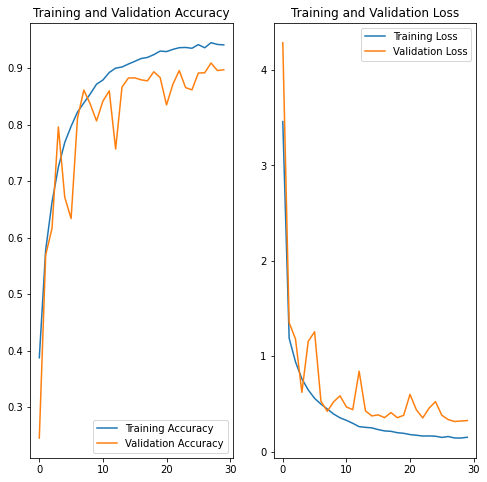

In [13]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Now we can see that our model is performing quiet well. The training and validation accuracies are high and are not far appart, which indicates there's no overfitting like our first model. 

Data augmentation helped in reducing overfitting but accuracy was low. Class rebalance has helped us get training accuracy up without overfitting.